## Analysing H1B Acceptance Trends 

H1B visa is a nonimmigrant visa issued to gradute level applicants allowing them to work in the United States. The employer sponsors the H1B visa for workers with theoretical or technical expertise in specialized fields such as in IT, finance, accounting etc. An interesting fact about immigrant workers is that about 52 percent of new Silicon valley companies were founded by such workers during 1995 and 2005. Some famous CEOs like Indira Nooyi (Pepsico), Elon Musk (Tesla), Sundar Pichai (Google),Satya Nadella (Microsoft) once arrived to the US on a H1B visa.\
**Motivation**: Our team consists of five international gradute students, in the future we will be applying for H1B visa. The visa application process seems very long, complicated and uncertain. So we decided to understand this process and use Machine learning algorithms to predict the acceptance rate and trends of H1B visa. 

### Data 
The data used in the project has been collected from <a href="https://www.foreignlaborcert.doleta.gov/performancedata.cfm">the Office of Foreign Labor Certification (OFLC).</a>The Data provides insight into each petition with information such as the Job title, Wage, Employer, Worksite location etc. To get the dataset click on the above link-> click on Disclosure data -> scroll down to H1B data.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install autocorrect
import pandas as pd
import numpy as np
import nltk,warnings
import clean_wage as cw
%matplotlib inline
import baseline as blc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statistics import mean
nltk.download('words')
from autocorrect import Speller 
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder #ONE HOT ENCODING
from sklearn.ensemble import RandomForestClassifier #Build model - Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
nltk.download('wordnet')

### Exploratory Data Analysis

Before we begin working on our data we need to understand the traits of our data which we accomplish using EDA. We see that we have about 260 columns , not all 260 columns have essential information that contributes to our analysis. Hence we pick out the columns such as case status( Accepted/ Denied) ,Employer, Job title etc.We can look at all the colums and the types of object in each column using cleaned.info(). We also use cleaned['column_name'].value counts to find the classes in the column along with the count. For feature engineering we are converting quantitative data to categorical.  

In [0]:
file=pd.read_csv('/content/gdrive/My Drive/H-1B_Disclosure_Data_FY2019.csv')#Read the csv file and store it in file

In [6]:
cleaned=file[['CASE_NUMBER','CASE_STATUS','CASE_SUBMITTED','DECISION_DATE','VISA_CLASS','FULL_TIME_POSITION','JOB_TITLE','SOC_CODE','SOC_TITLE',\
              'EMPLOYER_NAME','WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1','NAICS_CODE','WORKSITE_CITY_1','WORKSITE_STATE_1']]
cleaned.shape

(1048548, 15)

In [8]:
print(cleaned['VISA_CLASS'].value_counts()) # similarly we can find the categories in CASE_STATUS and 'FULL_TIME_POSITION'
# Visa class has many categories which are not of use , we require only H1B visa type , hence we drop all records with other visa types
cleaned.drop(labels=cleaned.loc[cleaned['VISA_CLASS']!='H-1B'].index , inplace=True)
#In case status we can drop withdrawn records and we can change certified-withdrawn to certified
cleaned.replace({"CASE_STATUS":"CERTIFIED-WITHDRAWN"},"CERTIFIED",inplace=True)
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='WITHDRAWN'].index , inplace=True)
warnings.simplefilter("ignore")
print(cleaned.info())

H-1B    629856
Name: VISA_CLASS, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664616
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CASE_NUMBER              629855 non-null  object 
 1   CASE_STATUS              629856 non-null  object 
 2   CASE_SUBMITTED           629856 non-null  object 
 3   DECISION_DATE            629856 non-null  object 
 4   VISA_CLASS               629856 non-null  object 
 5   FULL_TIME_POSITION       629856 non-null  object 
 6   JOB_TITLE                629856 non-null  object 
 7   SOC_CODE                 629852 non-null  object 
 8   SOC_TITLE                629852 non-null  object 
 9   EMPLOYER_NAME            629848 non-null  object 
 10  WAGE_RATE_OF_PAY_FROM_1  629852 non-null  object 
 11  WAGE_UNIT_OF_PAY_1       629852 non-null  object 
 12  NAICS_CODE               629855 non-null  float64
 13  WORKSITE_CIT

In [0]:
#the column wages has a mix of both string and float value types and some record have the symbol '$' which we want to remove
cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(type).value_counts()
cleaned['WAGES']=cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(cw.clean_wages).astype('float')
cleaned['WAGE_UNIT_OF_PAY_1'].value_counts()# the wage information that we have available has different unit of pay

In [0]:
# we convert the different units of pay to the type 'Year'
cleaned= cw.clean_wageUnit(np,cleaned)
cleaned.drop(columns=['WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1'],axis=1,inplace=True)#we can drop the columns as cleaning is complete
cleaned.dropna(inplace=True)# We can check if we have null records using cleaned.info() and drop null records

In [0]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([cw.remove_num(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace(',', '')
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([cw.remove_num(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned['SOC_TITLE'].str.replace(',', '')

In [0]:
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())
spell = Speller()
def lemmatize_text(text):
     return lemmatizer.lemmatize(text)
def spelling_checker(text):
     return spell(text)

In [0]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))

In [0]:
cleaned['WAGE_CATEGORY'] = cleaned['WAGES'].apply(cw.wage_feature_eng)

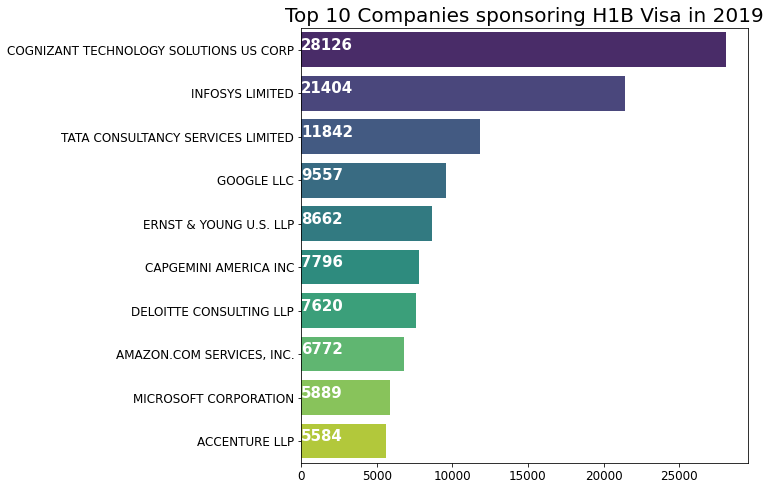

In [14]:
cleaned['EMPLOYER_NAME'].value_counts()
Top_Employer=cleaned['EMPLOYER_NAME'].value_counts()[:10]
plt.figure(figsize=[8,8])
ax=sns.barplot(y=Top_Employer.index,x=Top_Employer.values,palette=sns.color_palette('viridis',10))
ax.tick_params(labelsize=12)
for i, v in enumerate(Top_Employer.values): 
    ax.text(.5, i, v,fontsize=15,color='white',weight='bold')
plt.title('Top 10 Companies sponsoring H1B Visa in 2019', fontsize=20)
plt.show()

In [0]:
cleaned= cw.clean_states(cleaned)
cleaned= cw.drop_less_significant(cleaned)

In [0]:
data_scnt,data_anlst,data_eng,mach_learn=cw.data_jobs(cleaned)

## Are you an international student? Are you looking for jobs in Data Science domain?
The below visualization shows median salary for four data science related jobs and the number of visa applications that are submitted for each job. This gives us insights about the jobs available for international students/workers about the job market for Data Science domain. We get to know the number of jobs available for each caegory as well as the median wage for each category. 

So an applicant can wisely choose which job position to apply, based on thier preference of income oi visa approval

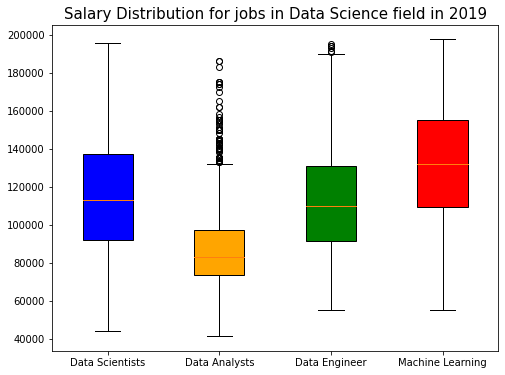

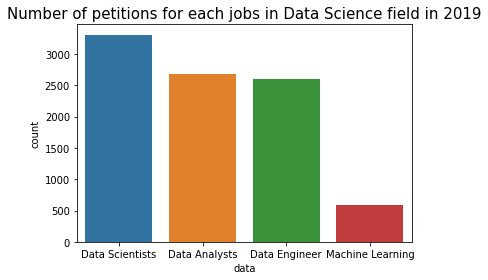

In [36]:
f,ax=plt.subplots(figsize=(8,6))
bplot1=plt.boxplot([data_scnt[data_scnt['WAGES']<200000].WAGES,data_anlst[data_anlst['WAGES']<200000].WAGES,data_eng[data_eng['WAGES']<200000].WAGES,mach_learn[mach_learn['WAGES']<200000].WAGES],patch_artist="True")
ax.set_xticklabels(['Data Scientists','Data Analysts','Data Engineer','Machine Learning'],fontsize=15)
ax.set_title('Salary Distribution for jobs in Data Science field in 2019', fontsize=15)
ax.tick_params(labelsize=10)
colors = ['blue','orange', 'green', 'red'] 
for patch, color in zip(bplot1['boxes'], colors): 
  patch.set_facecolor(color)
plt.show()
datajobs=cw.data_concat(pd,data_scnt,data_anlst,data_eng,mach_learn)
ax2=sns.countplot(x="data", data=datajobs)
ax2.set_title('Number of petitions for each jobs in Data Science field in 2019', fontsize=15)
warnings.simplefilter("ignore")

In [0]:
#CONVERTING CATEGORICAL COLUMNS INTO NUMERIC COLUMNS
cleaned=cw.cat_to_num(cleaned)

### Baseline classifier

The baseline classifier is done with a basic model. In this case we are taking the mean of the labels ('certified' and 'denied' for H1B visa approvals). It will give us the base accuracy to which we will compare our classifier's accuracy. Our classifier should have a better accuracy than the baseline classifier accuracy.


In [38]:
# This step assigns a binary class label (0 or 1) to each label for H1B visa approval. 
def create_class_labels(processed_data):
    y = np.where((processed_data['CASE_STATUS']== 1),1, 0)
    return y
X = cleaned['CASE_STATUS'].to_numpy()
y = create_class_labels(cleaned)# Groundtruth labels for the dataset
counts = cleaned['CASE_STATUS'].value_counts()
print(counts)
print('proportion: ', counts[0]/counts[1], ': 1')

1    477662
0      2200
Name: CASE_STATUS, dtype: int64
proportion:  0.0046057672580192685 : 1


In [0]:
def compute_accuracy(validation, predicted):
    comp = prediction == validation 
    match_counts = np.count_nonzero(comp == True) 
    clasifier_accuracy = match_counts/len(validation)
    return clasifier_accuracy  
def compute_AUC(y, prediction):
    auc = None
    try:
        auc = roc_auc_score(y, prediction)
    except ValueError:
        pass
    return auc

In [40]:
accuracies = []
AUCs = []
kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True)# Testing with K-folds 
for train_idx, test_idx in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx] 
    prediction = blc.run_clasifier(X_train, y_train, X_test, np)
    fold_accuracy = compute_accuracy(y_test, prediction)
    fold_AUC = compute_AUC(y_test, prediction)
    accuracies.append(fold_accuracy)
    if fold_AUC != None: AUCs.append(fold_AUC)
baseline_clasifier_accuracy = mean(accuracies)
print('Baseline accuracy: ', baseline_clasifier_accuracy)

Baseline accuracy:  0.9954153481971395


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)# Testing with regular split
prediction = blc.run_clasifier(X_train, y_train, X_test, np)
split_accuracy = compute_accuracy(y_test, prediction)
split_AUC = compute_AUC(y_test, prediction)
print('Baseline accuracy: ', split_accuracy)  
print('AUC K-fold: ', mean(AUCs))
print('AUC split (80-20): ', split_AUC)  

Baseline accuracy:  0.9949777541600242
AUC K-fold:  0.5
AUC split (80-20):  0.5


The accuracy results of the baseline classifier is 0.99. This result is due to the highly imbalanced data, where there are 624682 CERTIFIED applications and 5158 DENIED applications. The proportion of it is 121.10934470725087 to 1. Therefore, a performance measure based on the accuracy is not a good one. A better performance measure in imbalanced data is the Area under the ROC Curve (AUC). It meassures the likelihood that given two random points (one from the positive and one from the negative class) the classifier will rank the point from the positive class higher than the one from the negative one.

In [0]:
Dataset = cleaned[["CASE_STATUS", "FULL_TIME_POSITION","JOB_TITLE", "SOC_CODE", "SOC_TITLE", "EMPLOYER_NAME", "WORKSITE_STATE_1", "WAGE_CATEGORY"]]

In [0]:
def soc_code(x):
    if x in y:
        return x
    else:
        return 0
y = Dataset["SOC_CODE"].value_counts().head(70)
Dataset["TOP_SOC_CODE"] = Dataset["SOC_CODE"].apply(common_function)

In [0]:
def common_function(x):
    if x in y:
        return x
    else:
        return "others"
y = Dataset["JOB_TITLE"].value_counts().head(72)
Dataset["JOB_POSITION"] = Dataset["JOB_TITLE"].apply(common_function)
y = Dataset["SOC_TITLE"].value_counts().head(70)
Dataset["TOP_SOC_TITLE"] = Dataset["SOC_TITLE"].apply(common_function)
y = Dataset["EMPLOYER_NAME"].value_counts().head(70)
Dataset["TOP_EMPLOYER"] = Dataset["EMPLOYER_NAME"].apply(common_function)

In [0]:
Dataset.drop(columns=['JOB_TITLE','SOC_CODE','SOC_TITLE','EMPLOYER_NAME',],axis=1,inplace=True)
Encoding = OneHotEncoder(handle_unknown='ignore',sparse = True)
Encoding_df = pd.DataFrame(Encoding.fit_transform(Dataset[["WORKSITE_STATE_1","JOB_POSITION","TOP_SOC_CODE","TOP_SOC_TITLE","TOP_EMPLOYER"]]).toarray())
Dataset = Dataset.join(Encoding_df)
Dataset.drop(columns=['WORKSITE_STATE_1','JOB_POSITION','TOP_SOC_CODE','TOP_SOC_TITLE','TOP_EMPLOYER','WAGE_CATEGORY'],axis=1,inplace=True)

In [0]:
Y = Dataset['CASE_STATUS'].values
X = Encoding_df
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)#Split the date into training and test set
model_clf = RandomForestClassifier(n_jobs=2,random_state=0)
model_clf.fit(X_train,y_train)#train the model
prediction_test = model_clf.predict(X_test)#test the model (predict with our test data)
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))#compare with original value, Y_test

###Reflection
What is the hardest part of the project that you’ve encountered so far?
Setting up the data for visualization and ML analysis, e.g. same job title is cluttered with different words, integers, and punctuation characters. Encoding the dataset to be used in the Classifier was one the hardest part, which was later resolved by considering only the most values .

Are there any concrete results you can show at this point? If not, why not?
The concrete result that we have achieved is the acceptance of the H1B visa can be predicted, based on the Random-Forest-Classifier, which has shown 99% accuracy.

Going forward, what are the current biggest problems you’re facing?
One the issues we might encounter is using 'SMOTE' to balance out our data in a better way and handling additional data that will be included.

Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?
We are track with the project and will be able to accomplish all the results within the stipulated timeframe.

Given your initial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it’s better than your current results?
On the lines of the initial exploration, we conclude that proceeding with are project is worthy.

###Next steps:
What you plan to accomplish in the next month and how you plan to evaluate whether your project achieved the goals you set for it?
In the next month we plan to accomplish and present valid outcomes , we plan to apply another Machine-Learning Algorithm, predict the acceptance rates and provide another visualization based on the different states and their acceptance rates and also showcase the difference in the H1B visa acceptance after the policies that were enforced in the recent years. We will also combine the data from additional years.